In [3]:
import torch
from torch import nn, optim, autograd as grad
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, datasets 
import time
import random
import matplotlib.pyplot as plt # Use to map the sum squared gradient or the loss

This code classifies 10 different classes of images

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convL1 = nn.Conv2d(in_channels=3,out_channels=128, 
                                kernel_size=(3,3), stride= (1,1),padding=2)
        nn.init.kaiming_normal(self.convL1.weight)
        self.convL2 = nn.Conv2d(in_channels=128,out_channels=64, 
                                kernel_size=(3,3), stride= (1,1),padding=2)
        nn.init.kaiming_normal(self.convL2.weight)
        self.convL3 = nn.Conv2d(in_channels=64,out_channels=32, 
                                kernel_size=(2,2), stride= (1,1),padding=1)
        nn.init.kaiming_normal(self.convL1.weight)

        self.linL4 = nn.Linear(1568, 1000, bias=True)
        self.linL5 = nn.Linear(1000, 10, bias=True)
        nn.init.xavier_uniform_(self.linL4.weight)
        nn.init.xavier_uniform_(self.linL5.weight)

        self.pool3 = nn.MaxPool2d((3,3), (3,3))
        self.pool2 = nn.MaxPool2d((2,2), (2,2))


        self.relu = nn.ReLU()  
        self.Batch_norm = nn.BatchNorm1d(num_features=32)
        self.Lrelu = nn.LeakyReLU()
        self.softplus = nn.Softplus()
        self.Softmax = nn.Softmax()

    def forward(self, x):
        x=self.Batch_norm(x)
        x=self.relu(self.convL1(x))
        x=self.pool3(x)
        x=self.relu(self.convL2(x))
        x=self.pool2(x)
        x=self.relu(self.convL3(x))

        x=torch.flatten(x)
        x=self.relu(self.linL4(x))
        x=self.Softmax(self.linL5(x))
        return x

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

Additional Functions

In [5]:
def ret_shape(training_set)->str:
    ret_string = ""
    for idx, data in enumerate(training_set):
            datas = data[0]
            labels = data[1]
            ret_string+="{}\n".format(datas.shape)
            ret_string+="Labels:{}\n".format(labels)
            ret_string+="Labels shape:{}\n".format(len(labels))
            ret_string+="Labels[0] shape:{}\n".format(labels[0].shape)
            break
    return ret_string


def max_index(max_tnsr):
    max_tnsr = max_tnsr.tolist()
    max_num = 0
    for num in max_tnsr:
        if max_num < num:
            max_num = num
    return max_tnsr.index(max_num)


Train Cell:

In [6]:
FILE_PATH = "model.pth"
map_lst = []

def train_net(cnn, train_ds, dev):
    iter = 0

    # Selecting the optimization algorithm:
    optimizer = optim.SGD(params=cnn.parameters(), lr=8e-4,
                          momentum=0.2,
                          weight_decay=1e-4)
    #optimizer = optim.Adam(params=cnn.parameters(), weight_decay=0.1
    #                      , betas=[0.99, 0.999])

    # Training loop part
    for sample in train_ds:
        
        targetY = torch.nn.functional.one_hot(torch.tensor(sample[1]), num_classes=10) # Transforming to a binary vector
        targetY = torch.squeeze(
                    torch.tensor(targetY, dtype=torch.float32, requires_grad=True)
                ).to(dev)
              
        cnn = cnn.to(dev) # Added due to errors 
        pred = cnn.forward(torch.squeeze(sample[0]).to(dev))
        loss_func = nn.CrossEntropyLoss()
        # ---BackPropagation---
        loss = loss_func(pred, targetY)
        loss.backward()
        optimizer.step()

        if iter%100==0:
            torch.save(cnn.cpu(), FILE_PATH)
            grad_tmp = cnn.linL5.weight.grad
            print(iter," | ",grad_tmp.sum()/len(grad_tmp))
            map_lst.append([iter, grad_tmp.sum()/len(grad_tmp)])

        optimizer.zero_grad()
        iter+=1


In [ ]:
if __name__ == '__main__':

    # Accessing processing unit
    if torch.cuda.is_available() : device = "cuda:0"
    else : device = "cpu"
    device = torch.device(device)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    net = CNN().to(device)

    # Loading the dataset
    train_data = torchvision.datasets.CIFAR10(
        root= "C:/Users/orian/OneDrive/שולחן העבודה/My Coding Files"
        ,train=True, transform=transforms.Compose([transforms.ToTensor()])
        #, target_transform=transforms.Compose([transforms.ToTensor()])
    )
    
    valtest_dis = 0.5 # Determines the distribution between the validation and the test set
    valtest_ds= torchvision.datasets.CIFAR10(
        root= "C:/Users/orian/OneDrive/שולחן העבודה/My Coding Files"
        ,train=False, transform=transforms.Compose([transforms.ToTensor()]), 
    )
    val_data, test_data = random_split(
        valtest_ds, [int(len(valtest_ds)*valtest_dis),int(len(valtest_ds)*(1-valtest_dis))]
    )

    train_data = DataLoader(train_data, shuffle=True)
    train_net(net, train_data, dev=device)


Test Cell:

model's accuracy: 11.37 %
[91, 704, 0, 876, 167, 78, 819, 0, 1928, 337]


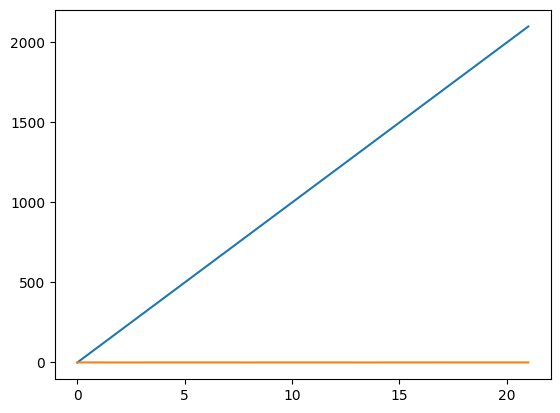

In [10]:
FILE = "model.pth"
model = torch.load(FILE)
model.eval()


image_lst = [0]*10
right_pred = 0
for i in range(len(test_data)):
    if max_index(model.forward(test_data[i][0]))==test_data[i][1]:
        right_pred+=1
    image_lst[max_index(model.forward(test_data[i][0]))]+=1
print("model's accuracy:",right_pred/100,"%")
print(image_lst)
plt.plot(map_lst)
plt.show()